# CS146 Final Project - Mahjong Statistics Prediction

In [86]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stan
import nest_asyncio
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns

# Deal with Python notebook compatability with stan
# See https://pystan.readthedocs.io/en/latest/faq.html#how-can-i-use-pystan-with-jupyter-notebook-or-jupyterlab
nest_asyncio.apply()

In [87]:
# Import dataset
raw_df = pd.read_csv("./dataset_2.csv", index_col=[0])
raw_df.head()

,time,rank,score
0,2022/4/17 07:24,4,15700
1,2022/4/17 06:55,1,34500
2,2022/4/17 06:10,3,20700
3,2022/4/17 05:27,1,43400
4,2022/4/17 04:19,1,44300


## Preprocessing

In [88]:
# create copy of df instance
df = raw_df

# Reverse all data (scraped from newest to oldest)
df = df[::-1]

# Change time column from string to datetime
df['time'] = pd.to_datetime(df['time'])
df.head()

,time,rank,score
1943,2021-02-20 19:25:00,4,6800
1942,2021-02-20 19:59:00,1,51400
1941,2021-02-20 20:49:00,2,26200
1940,2021-02-20 21:16:00,2,35700
1939,2021-02-20 22:39:00,1,47400


In [89]:
# Normalize score results with initial score
df['score'] = df['score']-25000
df.head()

,time,rank,score
1943,2021-02-20 19:25:00,4,-18200
1942,2021-02-20 19:59:00,1,26400
1941,2021-02-20 20:49:00,2,1200
1940,2021-02-20 21:16:00,2,10700
1939,2021-02-20 22:39:00,1,22400


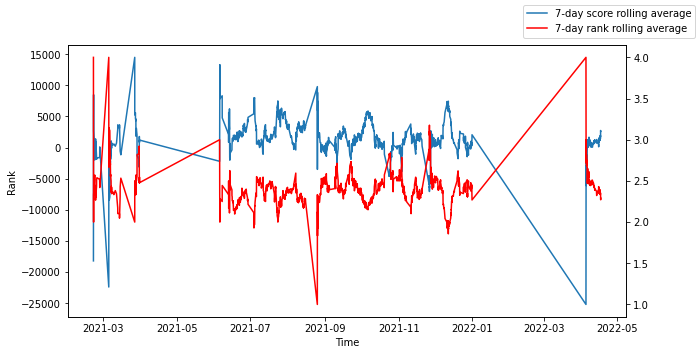

In [90]:
# Calculate weekly averages
df["7d_avg_score"] = df.rolling(window = '7D', on = 'time')['score'].mean()
df["7d_avg_rank"] = df.rolling(window = '7D', on = 'time')['rank'].mean()

# Plot data
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(df['time'], df["7d_avg_score"], label = "7-day score rolling average")

ax2 = ax1.twinx()
ax2.plot(df['time'], df["7d_avg_rank"], color= "red",label = "7-day rank rolling average")
ax1.set_xlabel("Time")
ax1.set_ylabel("Score")
ax1.set_ylabel("Rank")
fig.legend()
plt.show()

In [91]:
# Convert time data to timedelta for processing in stan
df['base_time'] = [df['time'].iloc[0] for _ in range(len(df))]
df['time_delta_min'] = (df['time'] - df['base_time']) / pd.Timedelta(minutes=1)

# Transform data type
df['time_delta_min'] = df['time_delta_min'].astype(int)
df['time_delta_min'].head()

Future exception was never retrieved
future: <Future finished exception=RuntimeError('write: Broken pipe')>
concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/enjuichang/opt/anaconda3/lib/python3.7/concurrent/futures/process.py", line 239, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/Users/enjuichang/VSProject/majong-soul/.venv/lib/python3.7/site-packages/httpstan/services_stub.py", line 47, in _make_lazy_function_wrapper_helper
    return function(*args, **kwargs)  # type: ignore
RuntimeError: write: Broken pipe
"""

The above exception was the direct cause of the following exception:

RuntimeError: write: Broken pipe


1943      0
1942     34
1941     84
1940    111
1939    194
Name: time_delta_min, dtype: int64

In [92]:
# Get win rate from rank (First place = win)
df['first_place'] = df['rank'].apply(lambda x: x == 1)

# Get average win rate
df["7d_avg_win"] = df.rolling(window = '7D', on = 'time')['first_place'].mean()


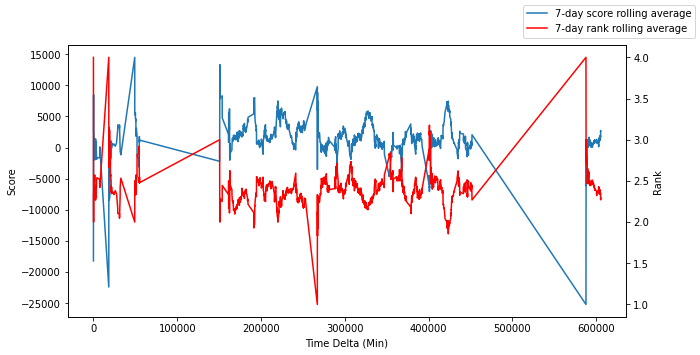

In [93]:
# Plot data
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(df['time_delta_min'], df["7d_avg_score"], label = "7-day score rolling average")

ax2 = ax1.twinx()
ax2.plot(df['time_delta_min'], df["7d_avg_rank"], color= "red",label = "7-day rank rolling average")
ax1.set_xlabel("Time Delta (Min)")
ax1.set_ylabel("Score")
ax2.set_ylabel("Rank")
fig.legend()
plt.show()

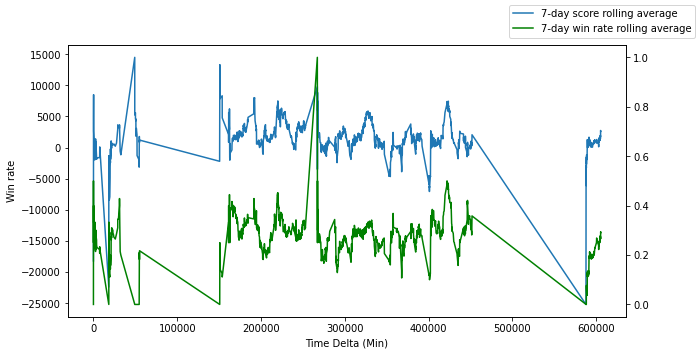

In [94]:
# Plot data
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(df['time_delta_min'], df["7d_avg_score"], label = "7-day score rolling average")

ax2 = ax1.twinx()
ax2.plot(df['time_delta_min'], df["7d_avg_win"], color= "green",label = "7-day win rate rolling average")
ax1.set_xlabel("Time Delta (Min)")
ax1.set_ylabel("Score")
ax1.set_ylabel("Win rate")

fig.legend()
plt.show()

## Model 1: Bayesian Linear Regression Model

This model predicts the score of the player based on time.

<img src="FP_model_1_graph.png" alt="model_1_graph" width="600"/>


In [95]:
# Write model 1
stan_code_1 = """
    data {
        int<lower=1> N;
        real<lower=0> time[N];
        real score[N];
    }
    parameters {
        real alpha;
        real beta;
        real<lower=0> sigma;
    }
    model {
        alpha ~ normal(0,2);
        beta ~ normal(0,1);
        sigma ~ cauchy(0,2);
        for (i in 1:N) {
        score[i] ~ normal(alpha + beta * time[i], sigma);
        }
    }
    """

In [96]:
# Compile the model
# Put our data in a dictionary
data = {
    'N': len(df), 
    'time': df['time_delta_min'].to_list(), 
    'score': df['7d_avg_score'].to_list()
}

model_1 = stan.build(program_code=stan_code_1, data=data)

Building...



Building: found in cache, done.

In [97]:
# Train the model and generate samples
results_1 = model_1.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (401/8000)
Sampling:   6% (501/8000)
Sampling:   8% (601/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2501/8000)
Sampling:  33% (2601/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

In [98]:
result_summary_1 = results_1.to_frame()
print(result_summary_1.describe()[['alpha','beta','sigma']].T[["25%",'50%','75%']])


                    25%          50%          75%
parameters                                       
alpha         -0.984936     0.376952     1.732830
beta           0.004226     0.004343     0.004468
sigma       2684.338804  2711.532868  2741.535302


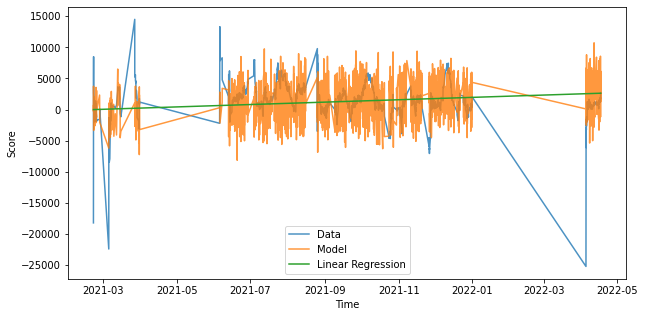

In [99]:
results_1_sampled = [np.random.normal(results_1['beta'].mean()*data['time'][i]+results_1['alpha'].mean(),results_1['sigma'].mean()) for i in range(len(data['time']))]
results_1_linear = results_1['beta'].mean()*np.asarray(data['time'])+results_1['alpha'].mean()
plt.figure(figsize=(10,5))
plt.plot(df['time'], df['7d_avg_score'], alpha = 0.8, label = "Data")
plt.plot(df['time'], results_1_sampled, alpha = 0.8, label = "Model")
plt.plot(df['time'], results_1_linear, label = "Linear Regression")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Score")
plt.show()


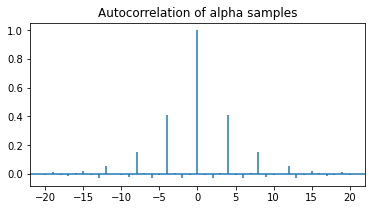

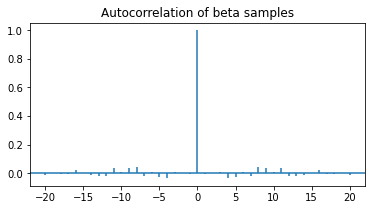

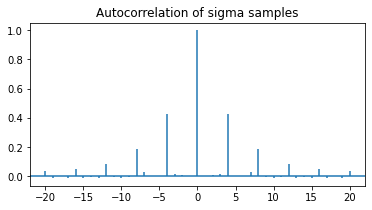

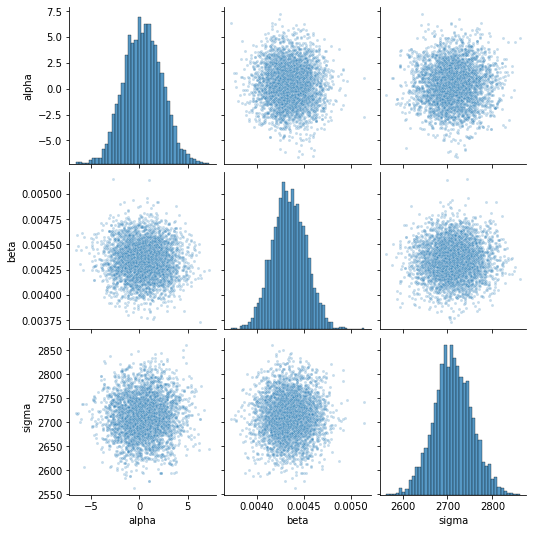

In [100]:
# Plot sample autocorrelation for each parameter.
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in ['alpha','beta','sigma']:
    plt.figure(figsize=(6, 3))
    plot_acf(results_1[param][0])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

# Get pair plot of the posteriors over all parameters of the model.
pairplot_df_1 = pd.DataFrame(
    data=np.transpose([results_1[param][0] for param in ['alpha','beta','sigma']]),
    columns=['alpha','beta','sigma'])
sns.pairplot(pairplot_df_1, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

### Prediction

In [101]:
# Train test split the data (not randomized as it's a time series)
def train_test_split(data, percent):
    threshold_index = int(len(data)*percent)
    train = data[:threshold_index]
    test = data[threshold_index:]
    return train, test

# Get train test split
train_time_1, test_time_1= train_test_split(df['time_delta_min'].to_list(), 0.75)
train_score_1, test_score_1= train_test_split(df['7d_avg_score'].to_list(), 0.75)

In [102]:
# Compile the model
# Put our data in a dictionary
data_train = {
    'N': len(train_time_1), 
    'time': train_time_1, 
    'score': train_score_1
}

model_1_train = stan.build(program_code=stan_code_1, data=data_train)

Building...



Building: found in cache, done.

In [103]:
# Train the model and generate samples
results_1_train = model_1_train.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   1% (101/8000)
Sampling:   1% (102/8000)
Sampling:   3% (202/8000)
Sampling:   4% (302/8000)
Sampling:   5% (401/8000)
Sampling:   6% (501/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2201/8000)
Sampling:  29% (2301/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  42% (3400/8000)
Sampling:  44% (3501/800

In [104]:
result_train_summary_1 = results_1_train.to_frame()
print(result_train_summary_1.describe()[['alpha','beta','sigma']].T[["25%",'50%','75%']])


                    25%          50%          75%
parameters                                       
alpha         -1.167703     0.193112     1.529065
beta           0.006694     0.006855     0.007018
sigma       2517.507353  2549.651596  2583.699016


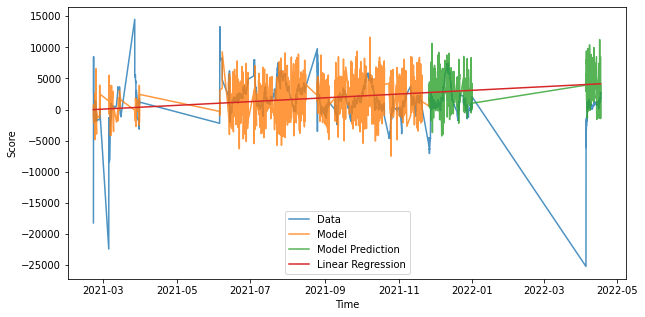

In [105]:
# One sample
results_1_train_sampled = [np.random.normal(results_1_train['beta'].mean()*data['time'][i]+results_1_train['alpha'].mean(),results_1_train['sigma'].mean()) for i in range(len(data['time']))]
results_1_train_linear = results_1_train['beta'].mean()*np.asarray(data['time'])+results_1_train['alpha'].mean()

plt.figure(figsize=(10,5))
plt.plot(df['time'], df['7d_avg_score'], alpha = 0.8, label = "Data")
plt.plot(df['time'][:len(data_train['time'])], results_1_train_sampled[:len(data_train['time'])], alpha = 0.8, label = "Model")
plt.plot(df['time'][len(data_train['time']):], results_1_train_sampled[len(data_train['time']):], alpha = 0.8, label = "Model Prediction")
plt.plot(df['time'], results_1_train_linear, label = "Linear Regression")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Score")
plt.show()


In [106]:
# Get new samples from posterior distribution
results_1_train_beta_mean = results_1_train['beta'].mean()
results_1_train_alpha_mean = results_1_train['alpha'].mean()
results_1_train_sigma_mean = results_1_train['sigma'].mean()
results_1_train_N = len(df['time'])

results_1_train_storage = np.empty(shape=(1000,results_1_train_N))

for i in range(1000):
    results_1_train_storage[i] = np.asarray([np.random.normal(results_1_train_beta_mean*data['time'][i]+results_1_train_alpha_mean,results_1_train_sigma_mean) for i in range(results_1_train_N)])

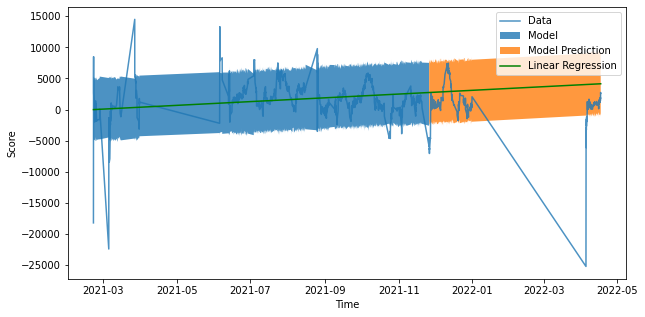

In [107]:
# Confidence envelope
results_1_train_upper = np.percentile(results_1_train_storage, 97.5, axis=0)
results_1_train_lower = np.percentile(results_1_train_storage, 2.5, axis=0)

# Get linear regression
results_1_train_linear = results_1_train['beta'].mean()*np.asarray(data['time'])+results_1_train['alpha'].mean()

# Plot figure
plt.figure(figsize=(10,5))
plt.plot(df['time'], df['7d_avg_score'], alpha = 0.8, label = "Data")
plt.fill_between(df['time'][:len(data_train['time'])], results_1_train_upper[:len(data_train['time'])], results_1_train_lower[:len(data_train['time'])], alpha = 0.8, label = "Model")
plt.fill_between(df['time'][len(data_train['time']):], results_1_train_upper[len(data_train['time']):], results_1_train_lower[len(data_train['time']):], alpha = 0.8, label = "Model Prediction")
plt.plot(df['time'], results_1_train_linear, color = "green", label = "Linear Regression")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Score")
plt.show()


In [108]:
# Test statistics
train_predict = results_1_train_storage[:,len(data_train['time']):]
real_data = data['score'][len(data_train['time']):]

# Get the rms and r2 from samples
rms_storage = []
r2_storage = []
for i in range(1000):
    rms_storage.append(mean_squared_error(real_data,train_predict[i]))
    r2_storage.append(r2_score(real_data, train_predict[i]))


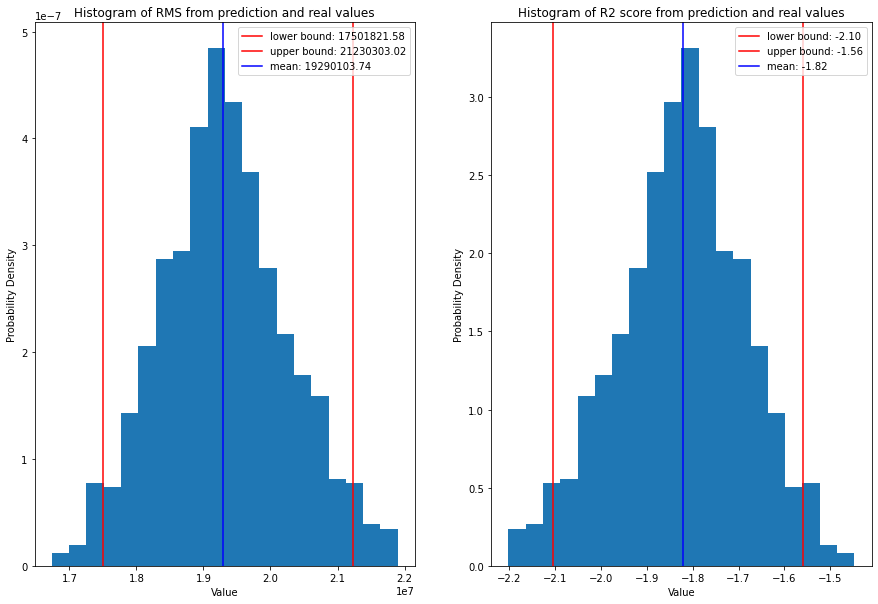

In [109]:
# Plot the test statistics
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))
ax1.hist(rms_storage, bins=20, density=True)
ax1.axvline(np.percentile(rms_storage,2.5), color = "red", label=f"lower bound: {np.percentile(rms_storage,2.5):.2f}")
ax1.axvline(np.percentile(rms_storage,97.5), color = "red", label=f"upper bound: {np.percentile(rms_storage,97.5):.2f}")
ax1.axvline(np.percentile(rms_storage,50), color = "blue", label=f"mean: {np.percentile(rms_storage,50):.2f}")
ax1.set_ylabel("Probability Density")
ax1.set_xlabel("Value")
ax1.set_title("Histogram of RMS from prediction and real values")
ax1.legend()
ax2.hist(r2_storage, bins=20, density=True)
ax2.axvline(np.percentile(r2_storage,2.5), color = "red", label=f"lower bound: {np.percentile(r2_storage,2.5):.2f}")
ax2.axvline(np.percentile(r2_storage,97.5), color = "red", label=f"upper bound: {np.percentile(r2_storage,97.5):.2f}")
ax2.axvline(np.percentile(r2_storage,50), color = "blue", label=f"mean: {np.percentile(r2_storage,50):.2f}")
ax2.set_ylabel("Probability Density")
ax2.set_xlabel("Value")
ax2.set_title("Histogram of R2 score from prediction and real values")
ax2.legend()
plt.show()

## Model 2: Hierarchical model based on model 1

This model predicts the rank of the player based on time and rank.

<img src="FP_model_2_graph.png" alt="model_2_graph" width="600"/>


In [110]:
# Write model 2
stan_code_2 = """
    data {
        int<lower=1> N;
        real<lower=0> time[N];
        real score[N];
        real<lower=1, upper=4> rank[N];
    }
    parameters {
        real alpha_s;
        real beta_s;
        real beta_r;
        real<lower=0> sigma_s;

    }
    model {
        alpha_s ~ normal(0,5); // initial score in game
        beta_s ~ normal(0,1);
        sigma_s ~ cauchy(0,2);
        beta_r ~ normal(0,1);
        for (i in 1:N) {
        score[i] ~ normal(alpha_s + beta_s * time[i] + beta_r * rank[i] , sigma_s);
        }
    }
    """

In [111]:
# Compile the model
# Put our data in a dictionary
data_2 = {
    'N': len(df), 
    'time': df['time_delta_min'].to_list(), 
    'score': df['7d_avg_score'].to_list(),
    'rank': df['7d_avg_rank'].to_list()
}

model_2 = stan.build(program_code=stan_code_2, data=data_2)

Building...



Building: found in cache, done.

In [112]:
# Train the model and generate samples
results_2 = model_2.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (401/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2901/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

In [113]:
result_summary_2 = results_2.to_frame()
# print(result_summary_2.describe()[['alpha','beta','sigma_s','sigma_r','scale_r']].T[["25%",'50%','75%']])
print(result_summary_2.describe()[['alpha_s','beta_s','sigma_s','beta_r']].T[["25%",'50%','75%']])

                    25%          50%          75%
parameters                                       
alpha_s       -0.567415     2.791283     6.165083
beta_s         0.004222     0.004347     0.004471
sigma_s     2679.309925  2710.623782  2740.211751
beta_r        -0.554433     0.125949     0.831483


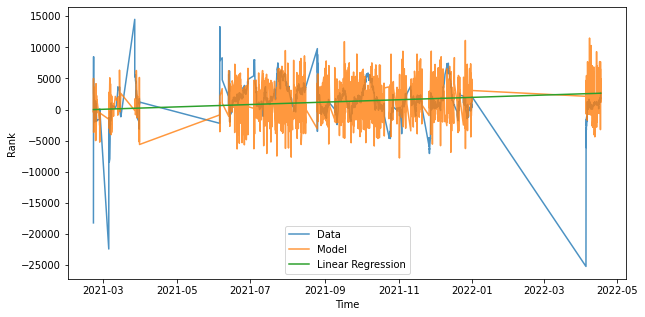

In [114]:
results_2_sampled = [np.random.normal(results_2['beta_s'].mean()*data_2['time'][i]+results_2['beta_r'].mean()*data_2['rank'][i]+results_2['alpha_s'].mean(),results_2['sigma_s'].mean()) for i in range(len(data_2['time']))]
results_2_linear = results_2['beta_r'].mean()*np.asarray(data_2['rank'])+results_2['beta_s'].mean()*np.asarray(data_2['time'])+results_2['alpha_s'].mean()


plt.figure(figsize=(10,5))
plt.plot(df['time'], df['7d_avg_score'], alpha = 0.8, label = "Data")
plt.plot(df['time'], results_2_sampled, alpha = 0.8, label = "Model")
plt.plot(df['time'], results_2_linear, label = "Linear Regression")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Rank")
plt.show()


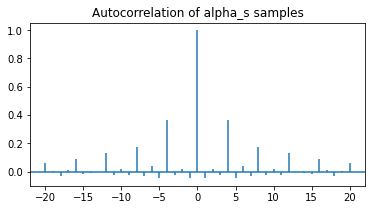

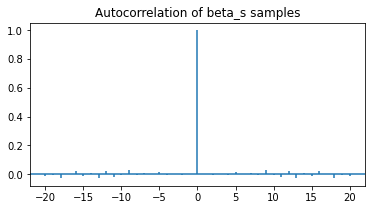

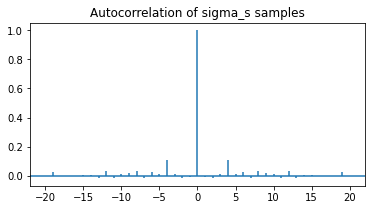

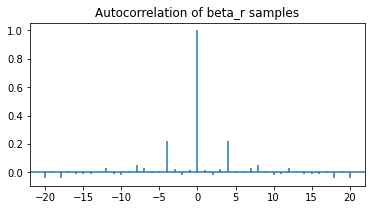

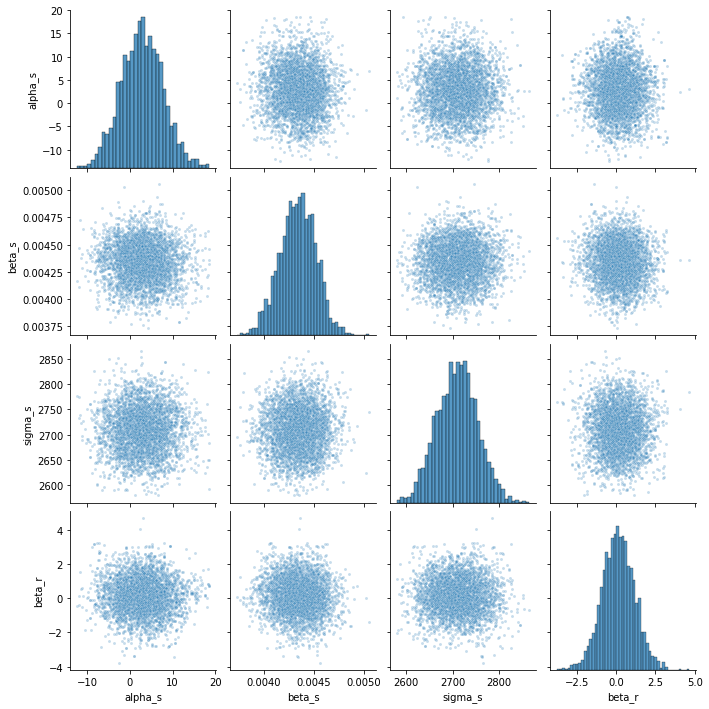

In [115]:
# Plot sample autocorrelation for each parameter.
for param in ['alpha_s','beta_s','sigma_s','beta_r']:
    plt.figure(figsize=(6, 3))
    plot_acf(results_2[param][0])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

# Get pair plot of the posteriors over all parameters of the model.
pairplot_df_2 = pd.DataFrame(
    data=np.transpose([results_2[param][0] for param in ['alpha_s','beta_s','sigma_s','beta_r']]),
    columns=['alpha_s','beta_s','sigma_s','beta_r'])
sns.pairplot(pairplot_df_2, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [116]:
# Get train test split
train_time_2, test_time_2= train_test_split(df['time_delta_min'].to_list(), 0.75)
train_score_2, test_score_2= train_test_split(df['7d_avg_score'].to_list(), 0.75)
train_rank_2, test_rank_2= train_test_split(df['7d_avg_rank'].to_list(), 0.75)

In [117]:
# Compile the model
# Put our data in a dictionary
data_train_2 = {
    'N': len(train_time_1), 
    'time': train_time_1, 
    'score': train_score_2, 
    'rank': train_rank_2
}

model_2_train = stan.build(program_code=stan_code_2, data=data_train_2)

Building...



Building: found in cache, done.

In [118]:
# Train the model and generate samples
results_2_train = model_2_train.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  33% (2601/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

In [119]:
result_train_summary_2 = results_2_train.to_frame()
print(result_train_summary_2.describe()[['alpha_s','beta_s','sigma_s','beta_r']].T[["25%",'50%','75%']])

                    25%          50%          75%
parameters                                       
alpha_s       -1.929432     1.190221     4.519375
beta_s         0.006674     0.006853     0.007019
sigma_s     2520.172312  2552.662368  2585.413593
beta_r        -0.645885     0.058235     0.727837


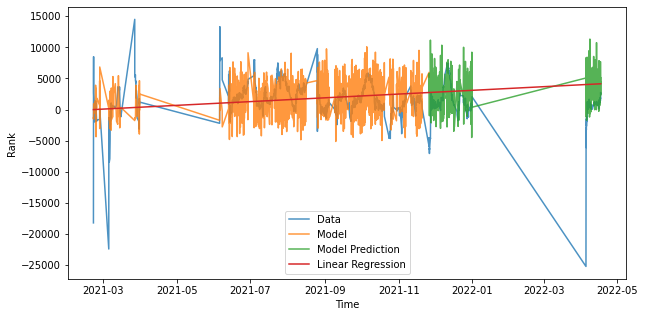

In [120]:
# One sample
results_2_train_sampled = [np.random.normal(results_2_train['beta_s'].mean()*data_2['time'][i]+results_2_train['beta_r'].mean()*data_2['rank'][i]+results_2_train['alpha_s'].mean(),results_2_train['sigma_s'].mean()) for i in range(len(data_2['time']))]
results_2_train_linear = results_2_train['beta_r'].mean()*np.asarray(data_2['rank'])+results_2_train['beta_s'].mean()*np.asarray(data_2['time'])+results_2_train['alpha_s'].mean()


plt.figure(figsize=(10,5))
plt.plot(df['time'], df['7d_avg_score'], alpha = 0.8, label = "Data")
plt.plot(df['time'][:len(data_train_2['time'])], results_2_train_sampled[:len(data_train_2['time'])], alpha = 0.8, label = "Model")
plt.plot(df['time'][len(data_train_2['time']):], results_2_train_sampled[len(data_train_2['time']):], alpha = 0.8, label = "Model Prediction")
plt.plot(df['time'], results_2_train_linear, label = "Linear Regression")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Rank")
plt.show()


In [121]:
# Get new samples from posterior distribution
results_2_train_beta_s_mean = results_2_train['beta_s'].mean()
results_2_train_alpha_s_mean = results_2_train['alpha_s'].mean()
results_2_train_sigma_s_mean = results_2_train['sigma_s'].mean()
results_2_train_beta_r_mean = results_2_train['beta_r'].mean()
results_2_train_N = len(df['time'])

results_2_train_storage = np.empty(shape=(1000,results_2_train_N))

for i in range(1000):
    results_2_train_storage[i] = np.asarray([np.random.normal(results_2_train_beta_r_mean*data_2['rank'][i]+results_2_train_beta_s_mean*data_2['time'][i]+results_2_train_alpha_s_mean,results_2_train_sigma_s_mean) for i in range(results_2_train_N)])

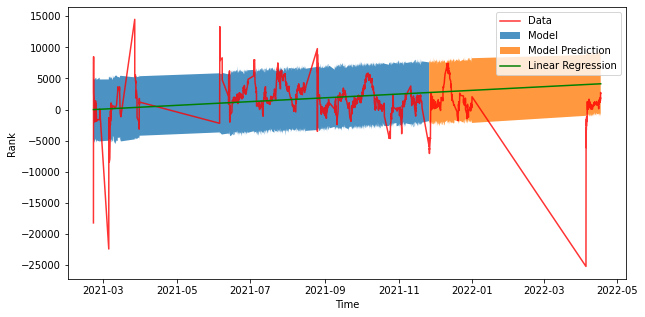

In [122]:
# Confidence envelope
results_2_train_upper = np.percentile(results_2_train_storage, 97.5, axis=0)
results_2_train_lower = np.percentile(results_2_train_storage, 2.5, axis=0)

# Get linear regression
results_2_train_linear = results_2_train['beta_r'].mean()*np.asarray(data_2['rank'])+results_2_train['beta_s'].mean()*np.asarray(data_2['time'])+results_2_train['alpha_s'].mean()

# Plot figure
plt.figure(figsize=(10,5))
plt.plot(df['time'], df['7d_avg_score'], color='red',alpha = 0.8, label = "Data")
plt.fill_between(df['time'][:len(data_train_2['time'])], results_2_train_upper[:len(data_train_2['time'])], results_2_train_lower[:len(data_train_2['time'])], alpha = 0.8, label = "Model")
plt.fill_between(df['time'][len(data_train_2['time']):], results_2_train_upper[len(data_train_2['time']):], results_2_train_lower[len(data_train_2['time']):], alpha = 0.8, label = "Model Prediction")
plt.plot(df['time'], results_2_train_linear, color = "green", label = "Linear Regression")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Rank")
plt.show()


In [123]:
# Test statistics
train_predict_2 = results_2_train_storage[:,len(data_train_2['time']):]
real_data_2 = data_2['score'][len(data_train_2['time']):]

# Get the rms and r2 from samples
rms_storage_2 = []
r2_storage_2 = []
for i in range(1000):
    rms_storage_2.append(mean_squared_error(real_data_2,train_predict_2[i]))
    r2_storage_2.append(r2_score(real_data_2,train_predict_2[i]))


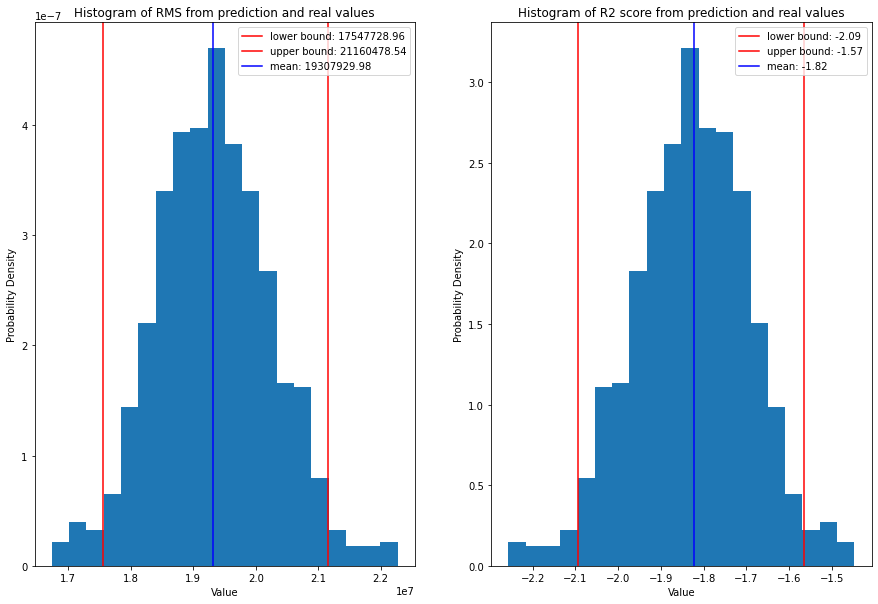

In [124]:
# Plot the test statistics
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))
ax1.hist(rms_storage_2, bins=20, density=True)
ax1.axvline(np.percentile(rms_storage_2,2.5), color = "red", label=f"lower bound: {np.percentile(rms_storage_2,2.5):.2f}")
ax1.axvline(np.percentile(rms_storage_2,97.5), color = "red", label=f"upper bound: {np.percentile(rms_storage_2,97.5):.2f}")
ax1.axvline(np.percentile(rms_storage_2,50), color = "blue", label=f"mean: {np.percentile(rms_storage_2,50):.2f}")
ax1.set_ylabel("Probability Density")
ax1.set_xlabel("Value")
ax1.set_title("Histogram of RMS from prediction and real values")
ax1.legend()
ax2.hist(r2_storage_2, bins=20, density=True)
ax2.axvline(np.percentile(r2_storage_2,2.5), color = "red", label=f"lower bound: {np.percentile(r2_storage_2,2.5):.2f}")
ax2.axvline(np.percentile(r2_storage_2,97.5), color = "red", label=f"upper bound: {np.percentile(r2_storage_2,97.5):.2f}")
ax2.axvline(np.percentile(r2_storage_2,50), color = "blue", label=f"mean: {np.percentile(r2_storage_2,50):.2f}")
ax2.set_ylabel("Probability Density")
ax2.set_xlabel("Value")
ax2.set_title("Histogram of R2 score from prediction and real values")
ax2.legend()
plt.show()

## Model 2-1: Another hierarchical model based on model 1

I tried incorporating the rank values not as another parameter with it's coefficient, but as a multiplier that shapes the model.

<img src="FP_model_2_1_graph.png" alt="model_2_1_graph" width="600"/>

In [125]:
# Write model 2-1
stan_code_2_1 = """
    data {
        int<lower=1> N;
        real<lower=0> time[N];
        real score[N];
        real<lower=1, upper=4> rank[N];
    }
    parameters {
        real alpha_s;
        real beta_s;
        real<lower=0> sigma_s;

    }
    model {
        alpha_s ~ normal(0,5); // initial score in game
        beta_s ~ normal(0,1);
        sigma_s ~ cauchy(0,2);
        for (i in 1:N) {
        score[i] ~ normal(alpha_s + beta_s * time[i] * rank[i] , sigma_s);
        }
    }
    """

In [126]:
# Compile the model
# Put our data in a dictionary
data_2 = {
    'N': len(df), 
    'time': df['time_delta_min'].to_list(), 
    'score': df['7d_avg_score'].to_list(),
    'rank': df['7d_avg_rank'].to_list()
}

model_2_1 = stan.build(program_code=stan_code_2_1, data=data_2)

# Train the model and generate samples
results_2_1 = model_2_1.sample(num_chains=4, num_samples=1000)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (401/8000)
Sampling:   6% (501/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sa

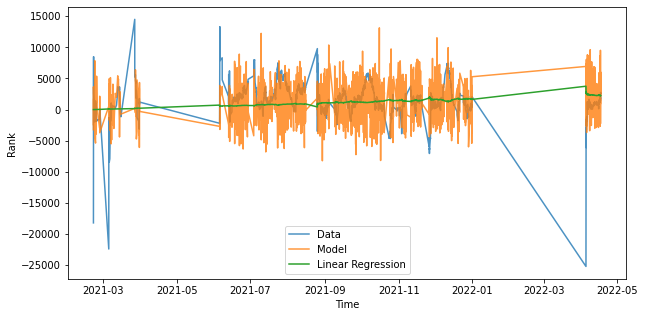

In [127]:
results_2_1_sampled = [np.random.normal(results_2_1['beta_s'].mean()*data_2['time'][i]*data_2['rank'][i]+results_2_1['alpha_s'].mean(),results_2_1['sigma_s'].mean()) for i in range(len(data_2['time']))]
results_2_1_linear = results_2_1['beta_s'].mean()*np.asarray(data_2['rank'])*np.asarray(data_2['time'])+results_2_1['alpha_s'].mean()

plt.figure(figsize=(10,5))
plt.plot(df['time'], df['7d_avg_score'], alpha = 0.8, label = "Data")
plt.plot(df['time'], results_2_1_sampled, alpha = 0.8, label = "Model")
plt.plot(df['time'], results_2_1_linear, label = "Linear Regression")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Rank")
plt.show()


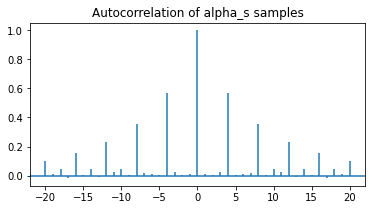

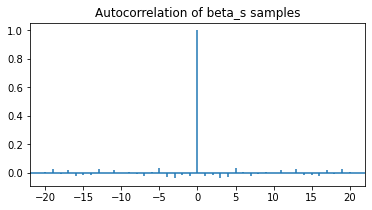

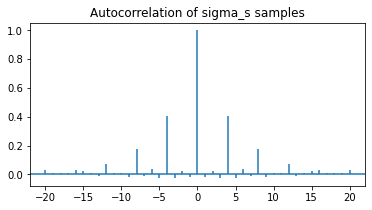

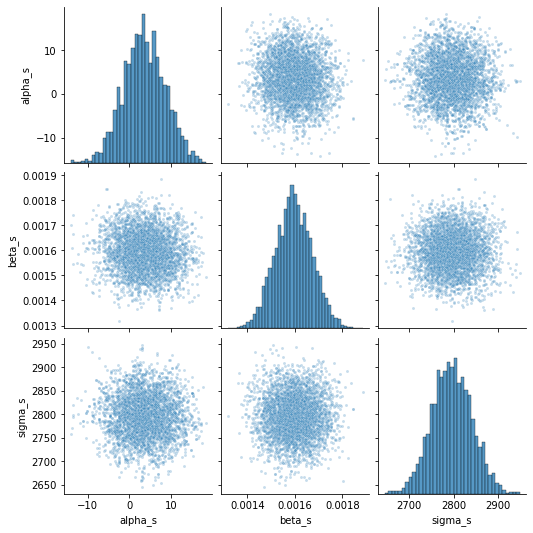

In [128]:
# Plot sample autocorrelation for each parameter.
for param in ['alpha_s','beta_s','sigma_s']:
    plt.figure(figsize=(6, 3))
    plot_acf(results_2_1[param][0])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

# Get pair plot of the posteriors over all parameters of the model.
pairplot_df_2_1 = pd.DataFrame(
    data=np.transpose([results_2_1[param][0] for param in ['alpha_s','beta_s','sigma_s']]),
    columns=['alpha_s','beta_s','sigma_s'])
sns.pairplot(pairplot_df_2_1, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [129]:
# Compile the model
model_2_1_train = stan.build(program_code=stan_code_2_1, data=data_train_2)

# Train the model and generate samples
results_2_1_train = model_2_1_train.sample(num_chains=4, num_samples=1000)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   1% (103/8000)
Sampling:   4% (302/8000)
Sampling:   5% (401/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2901/8000)
Sampling:  38% (3001/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  42% (3400/8000

In [130]:
result_train_summary_2_1 = results_2_1_train.to_frame()
print(result_train_summary_2_1.describe()[['alpha_s','beta_s','sigma_s']].T[["25%",'50%','75%']])

                    25%          50%          75%
parameters                                       
alpha_s       -2.024505     1.405355     4.829067
beta_s         0.002630     0.002701     0.002773
sigma_s     2598.219658  2631.712747  2666.678452


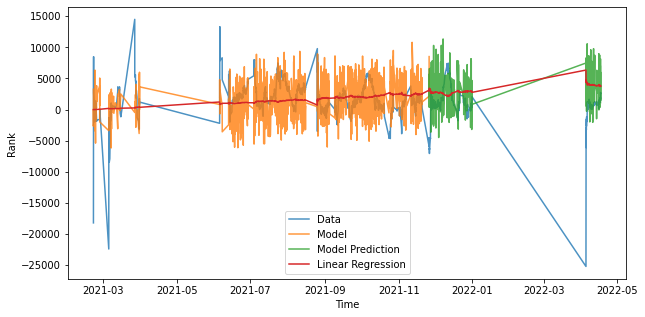

In [131]:
# One sample
results_2_1_train_sampled = [np.random.normal(results_2_1_train['beta_s'].mean()*data_2['time'][i]*data_2['rank'][i]+results_2_1_train['alpha_s'].mean(),results_2_1_train['sigma_s'].mean()) for i in range(len(data_2['time']))]
results_2_1_train_linear = np.asarray(data_2['rank'])*results_2_1_train['beta_s'].mean()*np.asarray(data_2['time'])+results_2_1_train['alpha_s'].mean()


plt.figure(figsize=(10,5))
plt.plot(df['time'], df['7d_avg_score'], alpha = 0.8, label = "Data")
plt.plot(df['time'][:len(data_train_2['time'])], results_2_1_train_sampled[:len(data_train_2['time'])], alpha = 0.8, label = "Model")
plt.plot(df['time'][len(data_train_2['time']):], results_2_1_train_sampled[len(data_train_2['time']):], alpha = 0.8, label = "Model Prediction")
plt.plot(df['time'], results_2_1_train_linear, label = "Linear Regression")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Rank")
plt.show()


In [132]:
# Get new samples from posterior distribution
results_2_1_train_beta_s_mean = results_2_train['beta_s'].mean()
results_2_1_train_alpha_s_mean = results_2_train['alpha_s'].mean()
results_2_1_train_sigma_s_mean = results_2_train['sigma_s'].mean()
results_2_train_N = len(df['time'])

results_2_1_train_storage = np.empty(shape=(1000,results_2_train_N))

for i in range(1000):
    results_2_1_train_storage[i] = np.asarray([np.random.normal(data_2['rank'][i]*results_2_1_train_beta_s_mean*data_2['time'][i]+results_2_1_train_alpha_s_mean,results_2_1_train_sigma_s_mean) for i in range(results_2_train_N)])

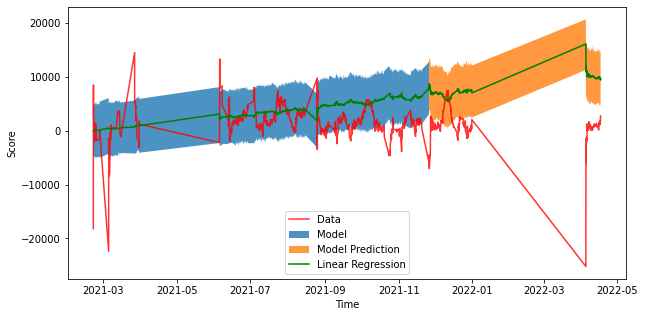

In [133]:
# Confidence envelope
results_2_1_train_upper = np.percentile(results_2_1_train_storage, 97.5, axis=0)
results_2_1_train_lower = np.percentile(results_2_1_train_storage, 2.5, axis=0)

# Get linear regression
results_2_1_train_linear = np.asarray(data_2['rank'])*results_2_train['beta_s'].mean()*np.asarray(data_2['time'])+results_2_train['alpha_s'].mean()

# Plot figure
plt.figure(figsize=(10,5))
plt.plot(df['time'], df['7d_avg_score'], color='red',alpha = 0.8, label = "Data")
plt.fill_between(df['time'][:len(data_train_2['time'])], results_2_1_train_upper[:len(data_train_2['time'])], results_2_1_train_lower[:len(data_train_2['time'])], alpha = 0.8, label = "Model")
plt.fill_between(df['time'][len(data_train_2['time']):], results_2_1_train_upper[len(data_train_2['time']):], results_2_1_train_lower[len(data_train_2['time']):], alpha = 0.8, label = "Model Prediction")
plt.plot(df['time'], results_2_1_train_linear, color = "green", label = "Linear Regression")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Score")
plt.show()


In [134]:
# Test statistics
train_predict_2_1 = results_2_1_train_storage[:,len(data_train_2['time']):]
real_data_2_1 = data_2['score'][len(data_train_2['time']):]

# Get the rms and r2 from samples
rms_storage_2_1 = []
r2_storage_2_1 = []
for i in range(1000):
    rms_storage_2_1.append(mean_squared_error(real_data_2_1,train_predict_2_1[i]))
    r2_storage_2_1.append(r2_score(real_data_2_1,train_predict_2_1[i]))


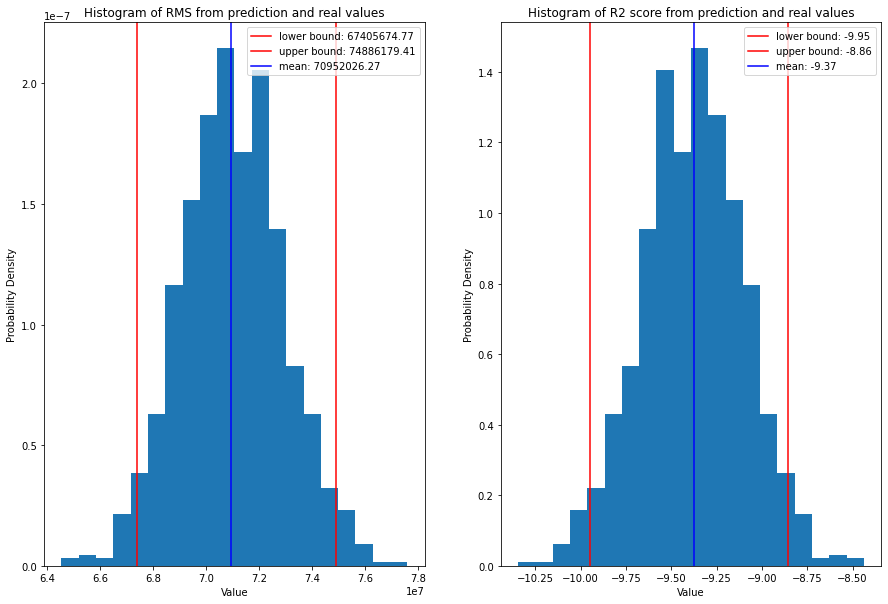

In [135]:
# Plot the test statistics
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))
ax1.hist(rms_storage_2_1, bins=20, density=True)
ax1.axvline(np.percentile(rms_storage_2_1,2.5), color = "red", label=f"lower bound: {np.percentile(rms_storage_2_1,2.5):.2f}")
ax1.axvline(np.percentile(rms_storage_2_1,97.5), color = "red", label=f"upper bound: {np.percentile(rms_storage_2_1,97.5):.2f}")
ax1.axvline(np.percentile(rms_storage_2_1,50), color = "blue", label=f"mean: {np.percentile(rms_storage_2_1,50):.2f}")
ax1.set_ylabel("Probability Density")
ax1.set_xlabel("Value")
ax1.set_title("Histogram of RMS from prediction and real values")
ax1.legend()
ax2.hist(r2_storage_2_1, bins=20, density=True)
ax2.axvline(np.percentile(r2_storage_2_1,2.5), color = "red", label=f"lower bound: {np.percentile(r2_storage_2_1,2.5):.2f}")
ax2.axvline(np.percentile(r2_storage_2_1,97.5), color = "red", label=f"upper bound: {np.percentile(r2_storage_2_1,97.5):.2f}")
ax2.axvline(np.percentile(r2_storage_2_1,50), color = "blue", label=f"mean: {np.percentile(r2_storage_2_1,50):.2f}")
ax2.set_ylabel("Probability Density")
ax2.set_xlabel("Value")
ax2.set_title("Histogram of R2 score from prediction and real values")
ax2.legend()
plt.show()

## Relationship between Rank and Score

This section shows the relationship between rank and score, justifying the use of rank to predict score in model 2.

In [136]:
# Sort values by rank
df_score = df.sort_values(by='7d_avg_score')
df_score.head()

,time,rank,score,7d_avg_score,7d_avg_rank,base_time,time_delta_min,first_place,7d_avg_win
179,2022-04-05 02:04:00,4,-25200,-25200.0,4.0,2021-02-20 19:25:00,587919,False,0.0
1912,2021-03-05 12:33:00,4,-22400,-22400.0,4.0,2021-02-20 19:25:00,18308,False,0.0
1943,2021-02-20 19:25:00,4,-18200,-18200.0,4.0,2021-02-20 19:25:00,0,False,0.0
1911,2021-03-05 13:10:00,3,-7500,-14950.0,3.5,2021-02-20 19:25:00,18345,False,0.0
178,2022-04-05 02:39:00,3,1500,-11850.0,3.5,2021-02-20 19:25:00,587954,False,0.0


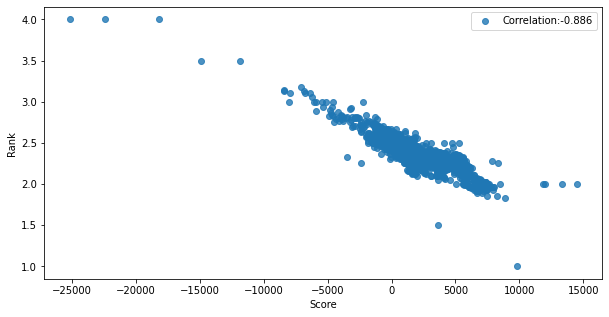

In [137]:
# Scatter plot and correlation between score and rank
plt.figure(figsize=(10,5))
plt.scatter(df_score['7d_avg_score'], df_score['7d_avg_rank'], 
    alpha = 0.8, label = f"Correlation:{np.corrcoef(df_score['7d_avg_score'], df_score['7d_avg_rank'])[0][1]:.3f}")
plt.legend()
plt.xlabel("Score")
plt.ylabel("Rank")
plt.show()
